In [1]:
import numpy as np
import pandas as pd

import time, datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
df = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

# Naive estimator

In [3]:
case_ids=df["case concept:name"].unique()
event_types=df["event concept:name"].unique()

In [4]:
def make_dict(event_types):
    fn={}
    cnt={}
    bk={}
    for j in event_types:
        cnt[j]=0
    for j in event_types:
        fn[j]=cnt
    return fn
info=make_dict(event_types)       
    

In [5]:
case_ids=df["case concept:name"].unique()
def can():  #helper fucntion of naive_est
    fn={} #key position , value most popular event for this position
    dx=df[["index",'position',"event concept:name"]].groupby(["position","event concept:name"]).count().reset_index()
    m=df["position"].unique()
    for pos in m:
        val=dx[dx["position"]==pos]["index"].idxmax()
        pop=dx[dx["position"]==pos]["event concept:name"][val]
        fn[pos]=pop
    return fn


def  naive_est(case_ids):
    db=can()
    def predict(x):
        try:
            return db[x+1]
        except KeyError:
                return db[x]
    
    df["next_event"]= df["position"].apply(predict)
    
    example_df= df[df["case concept:name"]==case_ids[0]]
    return  example_df[["event concept:name",'next_event']].head(5)

naive_est(case_ids)    

,event concept:name,next_event
0,A_SUBMITTED,A_PARTLYSUBMITTED
1,A_PARTLYSUBMITTED,W_Afhandelen leads
2,A_PREACCEPTED,W_Afhandelen leads
3,W_Completeren aanvraag,W_Completeren aanvraag
4,W_Completeren aanvraag,W_Completeren aanvraag


In [6]:
mp={ j:index+1 for index, j in enumerate(event_types)}

def label_event(x):
    try:
        return mp[x]
    except KeyError:
        return 1
df["label_y"]= df["event concept:name"].apply(label_event)
df["label_ypred"]= df["next_event"].shift(1).apply(label_event)
df["label_ypred"].head()

0     1
1     2
2    21
3    21
4     4
Name: label_ypred, dtype: int64

In [7]:
y_actu = df["label_y"] 
y_pred = df["label_ypred"]

new_df=pd.DataFrame()
new_df["resu"]=y_actu.eq(y_pred)
new_df["pred"]=y_pred

def rev(x):
    if x==False:
        return 0
    if x==True:
        return 1
new_df["pred"]= new_df["resu"].apply(rev)
new_df["resu"]=new_df["resu"].apply(rev)


In [8]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(new_df["resu"],new_df["pred"], labels=[0, 1]).ravel()
print(tn, fp, fn, tp) 

sm= { "TP":[tp,0], "TN":[0,tn]}
dm= pd.DataFrame(sm,index=["TP","TN"])
dm

154007 0 0 85780


,TP,TN
TP,85780,0
TN,0,154007


Text(0.5, 0, 'Accuracy')

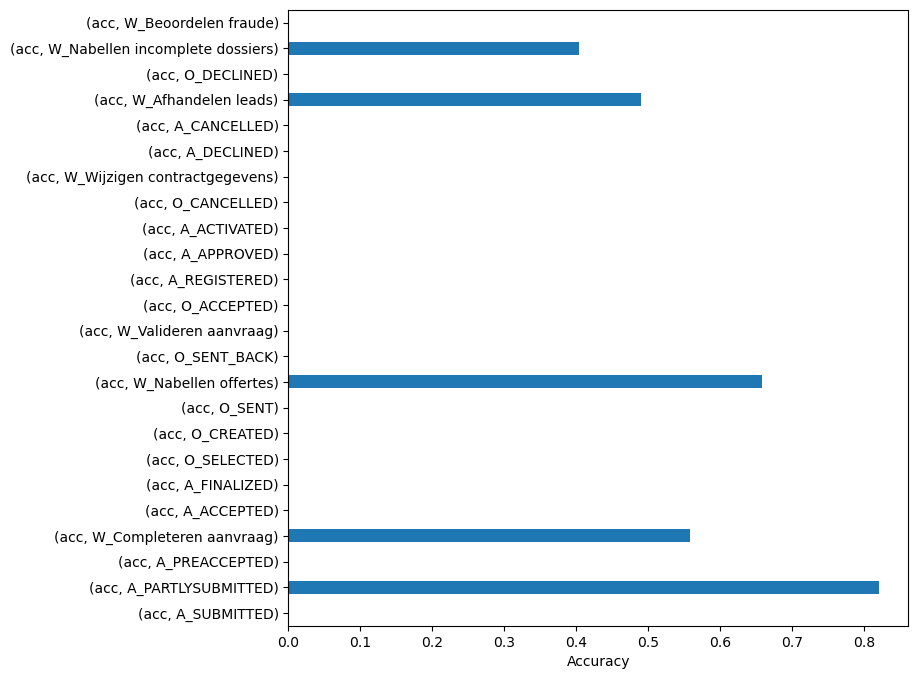

In [9]:
#plot acc per label
acc_label={}
for label in range(1,25):
    curr= df[df["label_y"]==label]
    y= curr["label_y"]
    yhat= curr["label_ypred"]
    p= y.eq(yhat).sum()
    psize= curr["label_y"].size
    acc_label[label]=  p/psize
    
    

pm= {mp[key]:key for key in mp}
fn_vis= {pm[key]: acc_label[key] for key in acc_label }

ax =pd.DataFrame(fn_vis,index=["acc"]).stack().plot(kind="barh",figsize=(8,8))
ax.set_xlabel("Accuracy")  

In [10]:
f1=f1_score(df["label_y"], df["label_ypred"], average='weighted')
glob_acc= (df["label_y"].eq(df["label_ypred"])).sum() /df["label_y"].size
pre =  precision_score(df["label_y"], df["label_ypred"], average='weighted')
recall=recall_score(df["label_y"], df["label_ypred"], average='weighted')
df_stats= pd.DataFrame( {"f1_score":f1, "Accurary":glob_acc,"Precision":pre,"Recall":recall},index=["baseline"])

df_stats

c:\Users\konst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1_score,Accurary,Precision,Recall
baseline,0.27682,0.357734,0.304055,0.357734


## CPU/RAM usage

In [12]:
import psutil
import time

# start measuring CPU and memory usage
process = psutil.Process()

# start point
start_time = time.time()

naive_est(case_ids)

# end point
end_time = time.time()

# calculate time taken
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

# measure CPU and memory usage
cpu_usage = process.cpu_percent()
memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"CPU usage: {cpu_usage:.2f}%")
print(f"Memory usage: {memory_usage:.2f} MB")

Time taken: 0.20 seconds
CPU usage: 0.00%
Memory usage: 291.54 MB
